In [1]:
import numpy as np
from numpy.linalg import inv, pinv, norm, qr
from matplotlib import pyplot as plt

In [3]:
def compute_SMW(n,k,A,B,U,V,lamda,e1,e2,rand_seed=1):
    # np.random.seed(rand_seed)    \
    # add noise
    noise1 = np.random.normal(size=(n,n))
    noise1 *= e1/norm(noise1,ord=2)
    noise2 = np.random.normal(size=(k,k))
    noise2 *= e2/norm(noise2,ord=2)

    A_inv = inv(A)
    A_til_inv = A_inv + noise1
    Z_inv = inv(np.eye(k)+V.T@A_til_inv@U) + noise2
    B_inv_approx = A_til_inv - A_til_inv@U@Z_inv@V.T@A_til_inv
    error = norm(B-inv(B_inv_approx),ord=2)
    beta = np.linalg.norm(np.eye(k)+V.T@A_inv@U,ord=2)
    bound = 4*lamda*e2*beta**2
    full_bound = 2*e1*norm(A,ord=2)**2 + 4*lamda*e2*(beta+lamda*e1)**2
    return error,bound,full_bound,2*e1*norm(A,ord=2)**2


In [75]:
lamda,sigma_min,sigma_max

(np.float64(1e-06), np.float64(1e-08), np.float64(0.01))

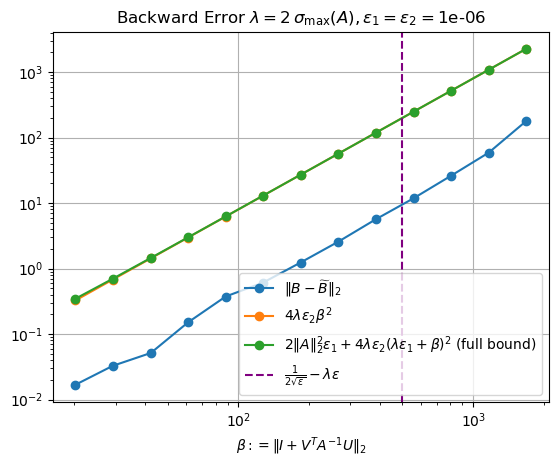

In [90]:
n = 500; k = 20
epsilon = 1e-6
num_experiments = 2
S_A = np.logspace(2,-2,n)
# S_A = list(np.logspace(-2,-8,int(n*0.6)))+[1e-8 for i in range(n-int(n*0.6))]
A = np.diag(S_A)
# U_A,_ = qr(np.random.randn(n,n))
# V_A,_ = qr(np.random.randn(n,n))
# A = U_A @ np.diag(S_A) @ V_A.T
sigma_max, sigma_min = np.max(S_A), np.min(S_A)
lamda = 2*sigma_max #2*sigma_max
assert epsilon < 1/2/sigma_max
index_list = list(range(int(n/4),int(n*3/4),20))
betas = np.zeros(len(index_list),dtype=float)
errors = np.zeros(len(betas),dtype=float)
bounds = np.zeros(len(betas),dtype=float)
full_bounds = np.zeros(len(betas),dtype=float)
first_terms = np.zeros(len(betas),dtype=float)

for i, index in enumerate(index_list):
    I = np.eye(n)
    Q = I[:, index:index + 20]
    U = A @ Q
    U_norm = norm(U, ord=2)
   
    V_norm = lamda / U_norm
    # print(V_norm)
    beta_total = 0.0
    error_total = 0.0
    bound_total = 0.0
    full_bound_total = 0.0
    first_term_total = 0.0

    for experiment in range(num_experiments):
        # Generate a new S for each experiment
        S = np.random.randn(k, k)
        S *= V_norm / norm(S, ord=2)
        V = Q @ S.T
        # Compute beta for this experiment
        beta = norm(np.eye(k) + V.T @ inv(A) @ U, ord=2)
        beta_total += beta
        assert epsilon < 1/2/(beta+lamda*epsilon)
        # assert 2*(beta+lamda*epsilon)**2 * epsilon < 0.5
        # Form B and compute the error and bounds using SMW update
        B = A + U @ V.T
        err, b, fb, ft = compute_SMW(n, k, A, B, U, V, lamda, epsilon, epsilon)
        error_total += err
        bound_total += b
        full_bound_total += fb
        first_term_total += ft

    # Store the average values over the experiments
    betas[i] = beta_total / num_experiments
    errors[i] = error_total / num_experiments
    bounds[i] = bound_total / num_experiments
    full_bounds[i] = full_bound_total / num_experiments
    first_terms[i] = first_term_total / num_experiments

plt.loglog(betas,errors,label=r'$\|B-\widetilde{B}\|_2$',marker='o')
plt.loglog(betas,bounds,label=r'$ 4\lambda\epsilon_2 \beta^2$',marker='o')
plt.loglog(betas,full_bounds,label=r'$2\|A\|_2^2\epsilon_1 + 4\lambda\epsilon_2 (\lambda\epsilon_1 + \beta)^2\text{ (full bound)}$',marker='o')
# plt.loglog(betas,first_terms,label=r'$2\|A\|_2^2\epsilon_1$')
x_val1 = 1/2/epsilon - lamda*epsilon
x_val2 = 1/2/np.sqrt(epsilon) - lamda*epsilon
# plt.axvline(x=x_val1, color = 'red', linestyle='--', label=r'$\frac{1}{2\epsilon}-\lambda \epsilon$')
plt.axvline(x=x_val2, color = 'purple',  linestyle='--', label=r'$\frac{1}{2\sqrt{\epsilon}}-\lambda \epsilon$')

plt.xlabel(r'$\beta := \|I + V^T A^{-1} U\|_{2}$')
plt.title("Backward Error "+r'$\lambda = 2\,\sigma_{\max}(A), \epsilon_1 = \epsilon_2 = $'+str(epsilon))
plt.legend()
plt.grid()
plt.savefig("diagonal_experiments/diagonal_backward_error_lambda_2_sigma_max_A_epsilon_1_2_1e-6.png")




In [78]:
epsilon , 1/2/sigma_max

(1e-06, np.float64(50.0))

In [74]:
betas

array([  1.023652  ,   1.05338065,   1.12146135,   1.3727598 ,
         1.86595705,   3.90962794,   8.00316489,  20.8387585 ,
        52.33811619, 100.17794522,  99.91203221, 100.03866818,
        99.97213078])

In [34]:
for beta in betas:
    # print(epsilon<1/(2*(beta + lamda*epsilon)))
    print(beta,epsilon<1/4/(beta + lamda*epsilon)**2)

1.0000013332848356 True
1.000002984436471 True
1.0000066590631624 True
1.0000128147314775 True
1.0000290317746376 True
1.0000597422500654 True
1.0001059244083152 True
1.0002354634383523 True
1.0004197672215782 True
1.00105076388571 True
1.002651166748198 True
1.004126772891976 True
1.0104572471847997 True


Text(0.5, 1.0, 'Backward Error $\\lambda = \\frac{1}{2}\\sigma_{\\max}(A), \\epsilon_1 = \\epsilon_2 = $1e-06')

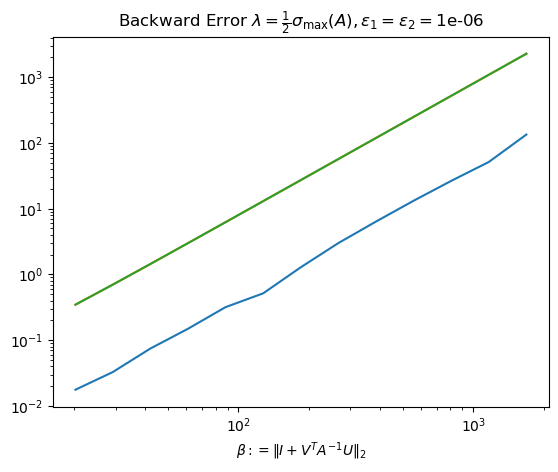

In [23]:
plt.loglog(betas,errors,label=r'$\|B-\widetilde{B}\|_2$')
plt.loglog(betas,bounds,label=r'$2\|A\|_2^2\epsilon_1 + 4\lambda\epsilon_2 \beta^2$')
plt.loglog(betas,full_bounds,label=r'$2\|A\|_2^2\epsilon_1 + 4\lambda\epsilon_2 (\lambda\epsilon_1 + \beta)^2\text{ (full bound)}$')
# plt.loglog(betas,first_terms,label=r'$2\|A\|_2^2\epsilon_1$')
plt.xlabel(r'$\beta := \|I + V^T A^{-1} U\|_{2}$')
plt.title("Backward Error "+r'$\lambda = \frac{1}{2}\sigma_{\max}(A), \epsilon_1 = \epsilon_2 = $'+str(epsilon))


In [24]:
# import numpy as np
# import matplotlib.pyplot as plt
# from brokenaxes import brokenaxes

# fig = plt.figure(figsize=(6,4))
# # Suppose you want two x-ranges:
# #   1) from 1e-1 to, say, 1e3
# #   2) from 1e5 to 1e7
# # so that you skip the big gap in between.
# bax = brokenaxes(
#     xlims=((6, 1e3), (1e5, 1e6)), 
#     xscale='log',yscale='log', # define the broken axis segments
#     hspace=.05,
#     wspace=0.2
# )

# # Plot data on brokenaxes object:
# bax.loglog(betas, errors, label=r'$\|B-\widetilde{B}\|_2$')
# bax.loglog(betas, bounds, label=r'$2\|A\|_2^2\epsilon_1 + 4\lambda\epsilon_2 \beta^2$')
# bax.loglog(betas, full_bounds, label='full bound')

# # Add vertical lines as well:
# bax.axvline(x=line1_position, linestyle='--', color='purple')
# bax.axvline(x=line2_position, linestyle='--', color='red')
# # bax.axs[0].set_xticks([1e0, 1e1, 1e2, 1e3 ])
# # bax.axs[0].set_xticklabels(['1e0', '1e1', '1e2', '1e3'])
# # bax.axs[1].set_xticks([1e5, 1e6])
# # bax.axs[1].set_xticklabels(['1e5', '1e6'])
# bax.legend()

# import matplotlib.ticker as ticker

# for ax in bax.axs:
#     ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#     ax.xaxis.set_minor_formatter(ticker.NullFormatter())  # optionally hide minor ticks
#     ax.tick_params(axis='x', which='major', rotation=0)  # or some rotation

# plt.show()


In [61]:
# n = 500
# k = 20
# epsilon = 1e-3
# num_experiments =2
# # S_A = [1/i**(1/2) for i in range(1,n+1)]
# S_A = np.logspace(3, -3, n)
# # S_A[-k] = S_A[-1]/10
# # S_A = [1/i for i in range(1,n+1)] # [100]*10+[100/i for i in range(1,n+1-20)]+[0.01]*10
# # A = np.diag(S_A)
# sigma_max, sigma_min = np.max(S_A), np.min(S_A)
# lamda = 2 * sigma_max
# beta_min,beta_max = lamda/(S_A[-k])+1, lamda/(S_A[-1])+1
# index_list = list(range(int(n / 4), int(n * 3 / 4), 20))

# # Declare output arrays (using "alphas" instead of "betas")
# # alphas = np.zeros(len(index_list), dtype=float)
# betas = np.logspace(np.log10(beta_min),np.log10(beta_max),len(index_list))
# errors = np.zeros(len(betas), dtype=float)
# bounds = np.zeros(len(betas), dtype=float)
# full_bounds = np.zeros(len(betas), dtype=float)
# first_terms = np.zeros(len(betas), dtype=float)
# # A = np.diag(S_A)
# U_A,_ = qr(np.random.randn(n,n))
# V_A,_ = qr(np.random.randn(n,n))
# A = U_A @ np.diag(S_A) @ V_A.T
# I = np.eye(n)
# Q = I[:,-k:]
# for i, index in enumerate(index_list):
#     beta = betas[i]
#     error_total = 0.0
#     bound_total = 0.0
#     full_bound_total = 0.0
#     first_term_total = 0.0
#     U = U_A@Q
#     S_diag = np.zeros(n)
#     S_diag[-k] = lamda
#     for j in range(n-k+1,n-1):
#         S_diag[j] = (beta-1)*S_A[j]*0.5 #(1/alpha-1)*S_A[j] #
#     S_diag[-1] = (beta-1)*S_A[-1]
#     # s_min, s_max = np.min(S_diag[-k:-1]), np.max(S_diag[-k:-1])
#     # S_diag[:n-k] = np.random.uniform(s_min,s_max,n-k) # [  (1/alpha-1)*S_A[j] for j in range(n-k)]# 
#     S = np.diag(S_diag)
#     V = V_A@S@Q
#     B = A + U @ V.T
#     assert abs(beta-norm(np.eye(k)+V.T@inv(A)@U,ord=2))/beta< 1e-3
#     assert abs(lamda-norm(U,ord=2)*norm(V,ord=2))/lamda<1e-3
#     for experiment in range(num_experiments):
#         err, b, fb, ft = compute_SMW(n, k, A, B, U, V, lamda, epsilon, epsilon)
#         error_total += err
#         bound_total += b
#         full_bound_total += fb
#         first_term_total += ft

#     # Store the average values over the experiments
#     errors[i] = error_total / num_experiments
#     bounds[i] = bound_total / num_experiments
#     full_bounds[i] = full_bound_total / num_experiments
#     first_terms[i] = first_term_total / num_experiments

# plt.loglog(betas,errors,label=r'$\|B-\widetilde{B}\|_2$')
# plt.loglog(betas,bounds,label=r'$2\|A\|_2^2\epsilon_1 + 4\lambda\epsilon_2 \beta^2$')
# plt.loglog(betas,full_bounds,label=r'$2\|A\|_2^2\epsilon_1 + 4\lambda\epsilon_2 (\lambda\epsilon_1 + \beta)^2\text{ (full bound)}$')
# plt.xlabel(r'$\beta := \|I + V^T A^{-1} U\|_{2}$')
# plt.title("Backward Error "+r'$\lambda = \frac{1}{2}\sigma_{\max}(A), \epsilon_1 = \epsilon_2 = $'+str(epsilon))
# plt.legend()
# plt.show()

